<a id='top'></a>
<a name="top"></a><!--Need for Colab-->
# Quick introduction to TensorFlow Serving

## MNIST CNN Model

Use Docker, subprocess module, trained / saved / loaded MNIST model, TensorFlow ModelServer APIs, and HTTP requests-logging.

1. [Setup](#setup)
2. [Introduction](#2.0)
3. [Using subprocess with TensorFlow Serving](#3.0)
4. [Train, save and load a MNIST model](#4.0)
    * 4.1 [Inspect the SavedModel Signature](#4.1)
5. [HTTP Request Logging for TensorFlow Serving](#5.0)
6. [Running a minimal Docker image with TensorFlow Serving](#6.0)
7. [Subprocess to write logs to file](#7.0)
    * [7.1 Verify logs](#7.1)
8. [RESTful APIs](#8.0)
    * [8.1 Model status API](#8.1)
    * [8.2 Model Metadata API](#8.2)
    * [8.3 Predict API](#8.3)
    * [8.4 Classify and Regress API](#8.4)
9. [Miscellaneous](#9.0)
10. [End and clean up processes](#10.0)

---
<a name="setup"></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [1]:
# stdlib imports
import asyncio
import glob
import json
import os
from pathlib import Path
import pprint
import shlex
import subprocess
import sys
import time

# third party imports
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf


# For debugging, provides version & hardware info
try:
    %load_ext watermark
except ImportError:
    print("Installing watermark:")
    !pip install watermark -q
    %load_ext watermark
finally:
    %watermark --python --packages matplotlib,numpy,requests,tensorflow
    
pp = pprint.PrettyPrinter(indent=2)

def HR():
    print("-"*40)

print("Finished loading packages..")

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

matplotlib: 3.5.1
numpy     : 1.22.4
requests  : 2.27.1
tensorflow: 2.9.1

Finished loading packages..


---
<a id="2.0"></a><a name="2.0"></a>
# 2. Introduction
<a href="#top">[back to top]</a>

We explore these tasks here:

* Using subprocess with TensorFlow Serving.
* HTTP Request Logging for TensorFlow Serving.
* Train / save / load the MNIST model.
* Running a minimal Docker image with TensorFlow Serving.
* Subprocess to write logs to file.

Reference:

https://tf.wiki/en/deployment/serving.html#en-call-serving-api

---
<a id="3.0"></a><a name="3.0"></a>
# 3. Using subprocess with TensorFlow Serving
<a href="#top">[back to top]</a>



A convenient way to use TensorFlow Serving is via Docker. We can operate the server and logging functions via Docker Commands on the CLI, but there are certain advantages (readability, maintenance, security, etc) to wrapping them in Python.

The older method of doing this involved using either os.system or os.spawn*. Here, we will instead use the newer subprocess module. This allows us to spawn new processes, connect to their input/output/error pipes, and optionally obtain their return codes. This is a safer analog to os.system().

The underlying process creation and management in `subprocess` is done by the [Popen Constructor](https://docs.python.org/3/library/subprocess.html#popen-constructor), `subprocess.Popen`. The underlying Popen interface can be used directly and offers the most flexibility. By default it results in a non-blocking call.

Once you've created the Popen instance, some options are:
* `wait()`:  to pause until the subprocess has exited.
* `poll()`: check if it's exited without pausing.
* `communicate()`: interact with process
    - Send data to stdin. 
    - Read data from stdout and stderr, until end-of-file is reached. 
    - Wait for process to terminate and set the returncode attribute. 


**Popen Constructor:**

<sup>

```bash
class subprocess.Popen(
    args, 
    bufsize=- 1, 
    executable=None, 
    stdin=None, 
    stdout=None, 
    stderr=None, 
    preexec_fn=None, 
    close_fds=True, 
    shell=False, 
    cwd=None, 
    env=None, 
    universal_newlines=None, 
    startupinfo=None, 
    creationflags=0, 
    restore_signals=True, 
    start_new_session=False, 
    pass_fds=(), 
    *, 
    group=None, 
    extra_groups=None, 
    user=None, 
    umask=- 1, 
    encoding=None, 
    errors=None, 
    text=None, 
    pipesize=- 1
)

```
<br>
</sup>
    
A convenience function built upon the underlying Popen interface is `subprocess.run`. This is a blocking call, as it waits for the command(s) to complete, then return a CompletedProcess instance.

There are older high-level APIs, existing prior to Python 3.5. The functionality provided by them has been superceded by `subprocess.Popen` and `subprocess.run`:

* `subprocess.call`
* `subprocess.check_call`
* `subprocess.check_output`


**Useful resources on subprocess:**

- https://peps.python.org/pep-0324/
- https://docs.python.org/3/whatsnew/2.4.html#pep-324-new-subprocess-module
- https://docs.python.org/3/library/subprocess.html
- https://www.bogotobogo.com/python/python_subprocess_module.php
- https://qiita.com/HidKamiya/items/e192a55371a2961ca8a4 (JP)
- https://www.programcreek.com/python/example/50/subprocess.Popen


---
<a id="4.0"></a><a name="4.0"></a>
# 4. Train, save and load a MNIST model
<a href="#top">[back to top]</a>

Here, we will train and save a CNN model for the MNIST dataset, then use Docker to deploy TensorFlow Serving to host this model.  We then make POST HTTP request with a JSON payload that contain test data. TensorFlow Serving will then make inferences, predicting the most probable image from among 10 categories.

Reference:
* https://www.tensorflow.org/tfx/tutorials/serving/rest_simple


In [2]:
# Define model_name and model_dir (used to start the Docker container)
model_saved = 'tf_server_data01'

# Create pathlib.PosixPath with fullpath via .resolve
model_dir = (Path() / model_saved).resolve()
model_dir.mkdir(parents=True, exist_ok=True)

model_name = 'mnist'

print(f"model_dir:\t{model_dir}")
print(f"model_name:\t{model_name}")

model_dir:	/Users/gb/Desktop/tf_server_01/tf_server_data01
model_name:	mnist


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Rescale to [0.0 .. 1.0]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0],28,28,1)
test_images = test_images.reshape(test_images.shape[0],28,28,1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        input_shape=(28,28,1),
        filters=8,
        kernel_size=3,
        strides=2,
        activation='relu',
        name='conv1'
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, name='dense')
])

epochs = 5

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

hist = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    verbose=2
)
                
version = 1
export_path = Path() / model_dir / str(version)


# We will manually save the model here, in SavedModel format.
# This creates a protobuf file in a structured directory hierarchy, and includes a version number.
# The model signature is defined by the input and output tensors, and stored with the serving_default key.
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

HR()

print("\nSaved model:")
!du -ah {export_path}

2022-08-08 11:29:54.410292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
1875/1875 - 6s - loss: 0.5687 - sparse_categorical_accuracy: 0.8002 - 6s/epoch - 3ms/step
Epoch 2/5
1875/1875 - 5s - loss: 0.4552 - sparse_categorical_accuracy: 0.8416 - 5s/epoch - 3ms/step
Epoch 3/5
1875/1875 - 5s - loss: 0.4206 - sparse_categorical_accuracy: 0.8534 - 5s/epoch - 3ms/step
Epoch 4/5
1875/1875 - 5s - loss: 0.3921 - sparse_categorical_accuracy: 0.8619 - 5s/epoch - 2ms/step
Epoch 5/5
1875/1875 - 5s - loss: 0.3645 - sparse_categorical_accuracy: 0.8711 - 5s/epoch - 3ms/step


INFO:tensorflow:Assets written to: /Users/gb/Desktop/tf_server_01/tf_server_data01/1/assets


INFO:tensorflow:Assets written to: /Users/gb/Desktop/tf_server_01/tf_server_data01/1/assets


----------------------------------------

Saved model:
 12K	/Users/gb/Desktop/tf_server_01/tf_server_data01/1/keras_metadata.pb
168K	/Users/gb/Desktop/tf_server_01/tf_server_data01/1/variables/variables.data-00000-of-00001
4.0K	/Users/gb/Desktop/tf_server_01/tf_server_data01/1/variables/variables.index
172K	/Users/gb/Desktop/tf_server_01/tf_server_data01/1/variables
 76K	/Users/gb/Desktop/tf_server_01/tf_server_data01/1/saved_model.pb
  0B	/Users/gb/Desktop/tf_server_01/tf_server_data01/1/assets
260K	/Users/gb/Desktop/tf_server_01/tf_server_data01/1


In [4]:
# Find the newest saved-model version
model_newest = max(glob.glob(f"{model_dir}/*"))
print(model_newest)

/Users/gb/Desktop/tf_server_01/tf_server_data01/1


<a id='4.1'></a><a name='4.1'></a>
## 4.1 Inspect the SavedModel Signature
<a href="#top">[back to top]</a>

We can use the tool `saved_model_cli` to inspect the SignatureDefs (the callable methods) of a model. This allows us to confirm the input Tensor dtype and shape matches the model.

Resources:
* https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel
* https://www.tensorflow.org/guide/saved_model
* https://blog.tensorflow.org/2021/03/a-tour-of-savedmodel-signatures.html
* https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

In [5]:
print("All tag-sets in the latest SavedModel:")
HR()
!saved_model_cli show --dir {model_newest}

All tag-sets in the latest SavedModel:
----------------------------------------
The given SavedModel contains the following tag-sets:
'serve'


In [6]:
print("All available SignatureDef keys in the MetaGraphDef specified by tag-set 'serve':")
HR()
!saved_model_cli show --dir {model_newest} --tag_set serve

All available SignatureDef keys in the MetaGraphDef specified by tag-set 'serve':
----------------------------------------
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [7]:
print("All inputs and outputs TensorInfo for the specific SignatureDef 'serving_default' in the MetaGraph:")
print("Note that shape: (-1) implies 1-D shape for inference data, eg {'examples': [{...}]}")
HR()

!saved_model_cli show --dir {model_newest} \
--tag_set serve --signature_def serving_default

All inputs and outputs TensorInfo for the specific SignatureDef 'serving_default' in the MetaGraph:
Note that shape: (-1) implies 1-D shape for inference data, eg {'examples': [{...}]}
----------------------------------------
The given SavedModel SignatureDef contains the following input(s):
  inputs['conv1_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_conv1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [8]:
print("All available information in the SavedModel:")
HR()
!saved_model_cli show --dir {model_newest} --all

All available information in the SavedModel:
----------------------------------------

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '

---
<a id="5.0"></a><a name="5.0"></a>
# 5. HTTP Request Logging for TensorFlow Serving
<a href="#top">[back to top]</a>

* The easiest way to enable logging for TensorFlow-Model-Serving is via environment variables. This is not specific to TensorFlow Serving, but general to TensorFlow.

* `TF_CPP_MIN_VLOG_LEVEL` enables logging of the main C++ backend. However, even the lowest setting of `TF_CPP_MIN_VLOG_LEVEL=1` results in too much noise.

* `TF_CPP_VMODULE` provides a way to constrain logging to specific modules or source files. The general format is `TF_CPP_VMODULE=<module_name>=1`, where the module name can be either the C++ or Python file name (without the extension).

* Here, we can activate logging individually for http_server.cc via 
`TF_CPP_VMODULE=http_server=1`. This will enable simple HTTP request logging and errors.

* To use this with Docker, we pass it as an environmental variable:  `--env TF_CPP_VMODULE=http_server=1`

---
<a name="6.0"></a>
# 6. Running a minimal Docker image with TensorFlow Serving
<a href="#top">[back to top]</a>

* This is the original Docker command-line format.

* `docker run` also pulls a docker image (or repository) from the docker registry, if it doesn't already exist locally.


This docker image features

* Port 8500 exposed for gRPC
* Port 8501 exposed for the REST API
* Optional environment variable MODEL_NAME (defaults to model)
* Optional environment variable MODEL_BASE_PATH (defaults to /models)

---

It can be easier to first to experiment and set up the Docker cli-commands first, then later wrap with subprocess.Popen in Python.

In [9]:
cmd_cli = f"""
docker run \\
--rm --tty -p 8500:8500 -p 8501:8501 \\
--name {model_name} \\
--mount type=bind,source={model_dir},target=/models/{model_name} \\
--env MODEL_NAME={model_name} \\
--env TF_CPP_VMODULE='http_server=1' \\
--detach \\
--log-driver=json-file \\
--log-opt=mode=non-blocking \\
tensorflow/serving:latest
"""

print(cmd_cli)


docker run \
--rm --tty -p 8500:8500 -p 8501:8501 \
--name mnist \
--mount type=bind,source=/Users/gb/Desktop/tf_server_01/tf_server_data01,target=/models/mnist \
--env MODEL_NAME=mnist \
--env TF_CPP_VMODULE='http_server=1' \
--detach \
--log-driver=json-file \
--log-opt=mode=non-blocking \
tensorflow/serving:latest



---
For more feedback, run these commands in different terminals before instantiating the Docker container:

```bash
$ watch docker ps
$ docker logs -f mnist
```

In [10]:
def server_docker():  
        
    cmd=f"""
docker run
--rm --tty -p 8500:8500 -p 8501:8501
--name {model_name}
--mount type=bind,source={model_dir},target=/models/{model_name}
--env MODEL_NAME={model_name}
--env TF_CPP_VMODULE='http_server=1'
--detach
--log-driver=json-file
--log-opt=mode=non-blocking
tensorflow/serving:latest
"""
           
    try:
        proc = subprocess.Popen(
            shlex.split(cmd),
            stdout = subprocess.PIPE,
            stderr = subprocess.PIPE
        )
        
        # The communicate() method returns a tuple (stdoutdata, stderrdata)
        # It only reads data from stdout and stderr.
        out, err = proc.communicate()
        out = out.decode()
        err = err.decode()
        print(f"out: {(out.strip())}")
        
        if err:
            print(f"err: {err}")
                
        HR()
        
        sleep_time = 0.5 # Small time delay for docker instance to start up
        time.sleep(sleep_time)
        
    except subprocess.CalledProcessError as e:
        print(f"Subprocess error: {e.stderr}")
    except Exception as e:
        print(f"Error: {e}")
        
    return proc 

In [11]:
# Instantiate TFS with our model 
proc = server_docker() 

out: fc81a987ec378232a65415cde70ea1834003be641c035588e9e04e950190517d
----------------------------------------


In [12]:
# If need to immediately kill and remove unused containers/networks/images
# !docker kill {model_name} && docker system prune --force

---
<a name="7.0"></a>
# 7. Subprocess to write logs to file
<a href="#top">[back to top]</a>

We can always access logs via `docker logs <container name>` on the CLI:

In [13]:
!docker logs --tail 5 {model_name}

2022-08-08 02:31:32.652551: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2022-08-08 02:31:32.654519: I tensorflow_serving/model_servers/server.cc:393] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
2022-08-08 02:31:32.655533: I tensorflow_serving/model_servers/server.cc:414] Exporting HTTP/REST API at:localhost:8501 ...
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


---
We can also create a subprocess that redirects the logs to a file:

In [14]:
def log_docker_process(log_file):  
    cmd = f"docker logs --follow {model_name}"   
    try:
        proc = subprocess.Popen(
            shlex.split(cmd),
            stdout=open(log_file, 'w'),
            stderr=subprocess.STDOUT, # redirect to stdout
        )
    except Exception as e:
        print(f"Error: {e}")

In [15]:
log_file = f"{model_name}_tfs.log"
print(f"log_file: {log_file}")

log_docker_process(log_file)

!du -hs {log_file}

log_file: mnist_tfs.log
  0B	mnist_tfs.log


<a name="7.1"></a>
## 7.1 Verify logs
<a href="#top">[back to top]</a>

Check that requests are being logged to the log file via the subprocess `log_docker_process`.

In [16]:
for x in range(10):
    
    try:
        resp_data = requests.get(f'http://localhost:8501/v1/models/{model_name}')
    except Exception as e:
        print(f"Error: {e}")
    
    print(f"===> TFS Status : {resp_data.headers['Date']} {resp_data}")
    time.sleep(0.2)
    
HR()
    
!du -h {log_file}
HR()
!tail -10 {log_file}

===> TFS Status : Mon, 08 Aug 2022 02:31:33 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:33 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:33 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:34 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:34 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:34 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:34 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:35 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:35 GMT <Response [200]>
===> TFS Status : Mon, 08 Aug 2022 02:31:35 GMT <Response [200]>
----------------------------------------
8.0K	mnist_tfs.log
----------------------------------------
2022-08-08 02:31:33.530977: I tensorflow_serving/model_servers/http_server.cc:162] Processing HTTP request: GET /v1/models/mnist body: 0 bytes.
2022-08-08 02:31:33.759751: I tensorflow_serving/model_servers/http_server.cc:162] Processing HTTP reques

---
<a name="8.0"></a>
# 8. RESTful APIs
<a href="#top">[back to top]</a>

Send requests with TensorFlow ModelServer RESTful APIs

Reference:

* https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/api_rest.md
* https://github.com/tensorflow/serving/blob/master/tensorflow_serving/model_servers/tensorflow_model_server_test.py#L520

<a name="8.1"></a>
## 8.1 Model status API
<a href="#top">[back to top]</a>

* Returns the status of a model in the ModelServer.
* If successful, returns a JSON representation of `GetModelStatusResponse` protobuf.

In [17]:
try:
    resp_data = requests.get(f'http://localhost:8501/v1/models/{model_name}')
except Exception as e:
    print(f"Error: {e}")

pp.pprint(resp_data.json())

HR()
!tail -1 {log_file}

{ 'model_version_status': [ { 'state': 'AVAILABLE',
                              'status': { 'error_code': 'OK',
                                          'error_message': ''},
                              'version': '1'}]}
----------------------------------------
2022-08-08 02:31:36.099137: I tensorflow_serving/model_servers/http_server.cc:162] Processing HTTP request: GET /v1/models/mnist body: 0 bytes.


<a name="8.2"></a>
## 8.2 Model Metadata API
<a href="#top">[back to top]</a>

* Returns the metadata of a model in the ModelServer. For example, we can inspect the details of the input and output tensors.
* Returns a JSON representation of `GetModelMetadataResponse` protobuf.

In [18]:
try:
    resp_data = requests.get(f'http://localhost:8501/v1/models/{model_name}/metadata')
except Exception as e:
    print(f"Error: {e}")

json_dump = (resp_data.json())
pp.pprint(repr(json_dump))

HR()

print("HTTP request log output:\n")
!tail -1 {log_file}

("{'model_spec': {'name': 'mnist', 'signature_name': '', 'version': '1'}, "
 "'metadata': {'signature_def': {'signature_def': {'serving_default': "
 "{'inputs': {'conv1_input': {'dtype': 'DT_FLOAT', 'tensor_shape': {'dim': "
 "[{'size': '-1', 'name': ''}, {'size': '28', 'name': ''}, {'size': '28', "
 "'name': ''}, {'size': '1', 'name': ''}], 'unknown_rank': False}, 'name': "
 "'serving_default_conv1_input:0'}}, 'outputs': {'dense': {'dtype': "
 "'DT_FLOAT', 'tensor_shape': {'dim': [{'size': '-1', 'name': ''}, {'size': "
 "'10', 'name': ''}], 'unknown_rank': False}, 'name': "
 "'StatefulPartitionedCall:0'}}, 'method_name': 'tensorflow/serving/predict'}, "
 "'__saved_model_init_op': {'inputs': {}, 'outputs': {'__saved_model_init_op': "
 "{'dtype': 'DT_INVALID', 'tensor_shape': {'dim': [], 'unknown_rank': True}, "
 "'name': 'NoOp'}}, 'method_name': ''}}}}}")
----------------------------------------
HTTP request log output:

2022-08-08 02:31:36.270775: I tensorflow_serving/model_servers/ht

<a name="8.3"></a>
## 8.3 Predict API
<a href="#top">[back to top]</a>

* The request body for predict API must be JSON object formatted as follows (for clarity, it may be easier to always include the "signature_name" field):

```bash
{
  // (Optional) Serving signature to use.
  // If unspecifed default serving signature is used.
  "signature_name": <string>,

  // Input Tensors in row ("instances") or columnar ("inputs") format.
  // A request can have either of them but NOT both.
  "instances": <value>|<(nested)list>|<list-of-objects>
  "inputs": <value>|<(nested)list>|<object>
}
```

* The predict request returns a JSON object in response body.

In [19]:
# Command line

# Check shape of data
num_samples = 1
test_payload = test_images[0:num_samples]
print(f"Shape of data passed to JSON payload: {test_payload.shape}")

# Show just a tiny subset
img_data = test_payload.tolist()
data = json.dumps({
    "signature_name": "serving_default",
    "instances": img_data
})

!curl -d '{data}' \
    -H 'cache-control: no-cache' \
    -X POST http://localhost:8501/v1/models/mnist:predict

print()
HR()

print("HTTP request log output:\n")
!tail -1 {log_file}

Shape of data passed to JSON payload: (1, 28, 28, 1)
{
    "predictions": [[-8.13978, -8.8744688, -5.46380091, -5.25820065, -6.30528641, 2.06250715, -3.4312284, 4.34305763, 1.11544907, 6.01798868]
    ]
}
----------------------------------------
HTTP request log output:

2022-08-08 02:31:36.501953: I tensorflow_serving/model_servers/http_server.cc:162] Processing HTTP request: POST /v1/models/mnist:predict body: 9585 bytes.


Shape of data passed to JSON payload: (3, 28, 28, 1)
shape[0] is 3, this means we will pass 3 samples.
----------------------------------------
Properties of response:

{ '_content': b'{\n    "predictions": [[-8.13977814, -8.87447071, -5.46380186'
              b', -5.2582, -6.30528688, 2.06250668, -3.43122959, 4.34305859,'
              b' 1.11544895, 6.01798868], [-3.00336146, -10.0945168, 2.55970'
              b'287, -7.78681707, 0.0381838679, -27.8272285, -0.0862028897, '
              b'-35.2029839, -7.38741636, -22.3393478], [-1.56377709, 12.431'
              b'6368, -5.56736517, 0.135994464, -0.749776959, -16.9869976, -'
              b'5.71387768, -14.4298296, -4.49142742, -13.6879396]\n    ]\n}',
  '_content_consumed': True,
  '_next': None,
  'connection': <requests.adapters.HTTPAdapter object at 0x12f87db20>,
  'cookies': <RequestsCookieJar[]>,
  'elapsed': datetime.timedelta(microseconds=11380),
  'encoding': 'utf-8',
  'headers': {'Content-Type': 'application/json', 'Dat

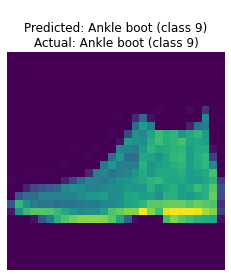

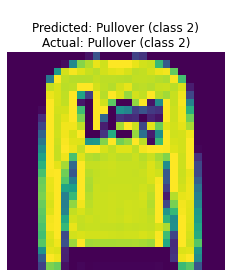

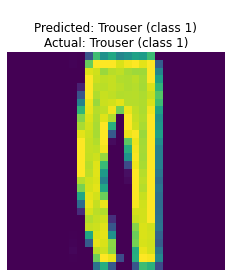

In [20]:
# In Python

def show(idx, title):
    plt.figure()
    plt.imshow(test_images[idx].reshape(28,28))    
    plt.axis('off')
    plt.title(f'\n{title}')
  
# ndarray is not JSON serializable, so we have to transform 
# test_images to a regular Python list before making the HTTP request.

# Check shape of data
num_samples = 3
test_payload = test_images[0:num_samples]
print(f"Shape of data passed to JSON payload: {test_payload.shape}")

if test_payload.shape[0] == 1:
    sample_text = 'sample'
else:
    sample_text = 'samples'
print(f"shape[0] is {test_payload.shape[0]}, this means we will pass {test_payload.shape[0]} {sample_text}.")

HR()

img_data = test_payload.tolist()

# Show just a tiny subset
data = json.dumps({
    "signature_name": "serving_default",
    "instances": img_data
})


headers = {
    "Content-type": "application_json"
}

json_response = requests.post(
    f'http://localhost:8501/v1/models/{model_name}:predict',
    data=data,
    headers=headers
)

# the JSON object must be str, bytes or bytearray, not Response
predictions = json.loads(json_response.text)['predictions']

for i in range(0, num_samples):
    forecast = class_names[np.argmax(predictions[i])]
    forecast_class = np.argmax(predictions[i])
    actual = class_names[test_labels[i]]
    actual_class = test_labels[i]
    show(
        i, 
        f"""Predicted: {forecast} (class {forecast_class})\nActual: {actual} (class {actual_class})"""
    )
    
print("Properties of response:\n")
pp.pprint(json_response.__dict__)

<a name="8.4"></a>
## 8.4 Classify and Regress API
<a href="#top">[back to top]</a>

To-do

---
<a name="9.0"></a>
# 9. Miscellaneous
<a href="#top">[back to top]</a>

In [21]:
# Check environmental variables of this container
!docker exec {model_name} env

PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
HOSTNAME=fc81a987ec37
MODEL_NAME=mnist
TF_CPP_VMODULE=http_server=1
MODEL_BASE_PATH=/models
HOME=/root


In [22]:
# Using jq:
!docker inspect {model_name} | jq '.[] | .Config.Env'

[
  "MODEL_NAME=mnist",
  "TF_CPP_VMODULE=http_server=1",
  "PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin",
  "MODEL_BASE_PATH=/models"
]


In [23]:
# As a toy example, we log into the container and check this environmental variable:
!docker exec -it {model_name} /bin/bash | echo TF_CPP_VMODULE

TF_CPP_VMODULE


In [24]:
def show_tfs_dict(proc):
    print("Properties of returned container process:\n")
    for key in proc.__dict__:
        if key == 'args':
            HR()
            print(key, '->', proc.__dict__[key])
            HR()
        else:
            print(key, '->', proc.__dict__[key])
 
show_tfs_dict(proc)

Properties of returned container process:

_waitpid_lock -> <unlocked _thread.lock object at 0x12eab9300>
_input -> None
_communication_started -> True
----------------------------------------
args -> ['docker', 'run', '--rm', '--tty', '-p', '8500:8500', '-p', '8501:8501', '--name', 'mnist', '--mount', 'type=bind,source=/Users/gb/Desktop/tf_server_01/tf_server_data01,target=/models/mnist', '--env', 'MODEL_NAME=mnist', '--env', 'TF_CPP_VMODULE=http_server=1', '--detach', '--log-driver=json-file', '--log-opt=mode=non-blocking', 'tensorflow/serving:latest']
----------------------------------------
stdin -> None
stdout -> <_io.BufferedReader name=82>
stderr -> <_io.BufferedReader name=84>
pid -> 20409
returncode -> 0
encoding -> None
errors -> None
text_mode -> None
_sigint_wait_secs -> 0.25
_closed_child_pipe_fds -> True
_child_created -> True
_fileobj2output -> {<_io.BufferedReader name=82>: [b'fc81a987ec378232a65415cde70ea1834003be641c035588e9e04e950190517d\n', b''], <_io.BufferedReader

---
<a name="10.0"></a>
# 10. End and clean up processes
<a href="#top">[back to top]</a>

In [25]:
# Kill and remove unused containers, networks, image
!docker kill {model_name} && docker system prune --force

mnist
Total reclaimed space: 0B


---
## Content Attribution

Portions of this page are modifications based on work created and shared by Google and used according to terms described in the Creative Commons 4.0 Attribution License.

This notebook is originally based on [Train and serve a TensorFlow model with TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple), created by Google.

## Code Attribution

Copyright 2020 The TensorFlow Authors.

In [26]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.